In [2]:
%matplotlib widget

#from IPython import display
from base64 import b64decode
from pacti.terms.polyhedra import *
from pacti.iocontract import IoContract, Var
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import patches
import pdb
from matplotlib.collections import PatchCollection
from contract_utils import *

varPrefixes=["t", "soc", "d", "c", "u", "r", "temp"]
epsilon = 1e-3

## Navigation viewpoint modeling

### CHARGING Task

Objective: charge the spacecraft battery

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with a fixed impact:
- the spacecraft's attitude change to the Sun injects a small disturbance that increases the trajectory estimation uncertainty.


In [15]:
# Parameters:
# - s: start index of the timeline variables
# - disturbance: (min, max) rate of navigation trajectory disturbance
#                due to the change in spacecraft attitude for pointing to the Sun.
# - epsilon: approximately zero
def CHARGING_nav(s: int, disturbance: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"u{s}_entry",    # initial trajectory estimation uncertainty
      f"r{s}_entry",    # initial relative trajectory distance
    ],
    OutputVars = [
      f"u{s}_exit",     # final trajectory estimation uncertainty
      f"r{s}_exit",     # final relative trajectory distance
    ],
    assumptions = [
      # 0 <= u{s}_entry <= 100
      f"-u{s}_entry <= 0",
      f" u{s}_entry <= 100",

      # 0 <= r{s}_entry <= 100
      f"-r{s}_entry <= 0",
      f" r{s}_entry <= 100",
    ],
    guarantees = [
      # disturbance(min) <= u{exit} - u{entry} <= disturbance(max)
      f" u{s}_exit - u{s}_entry <=  {disturbance[1]}",
      f"-u{s}_exit + u{s}_entry <= -{disturbance[0]}",

      # no change to relative trajectory distance
      f"r{s}_exit - r{s}_entry = 0",
    ])
  return spec

charging1_nav = CHARGING_nav(s=2, disturbance=(1.0, 2.0))
print(f"Contract charging1_nav:\n\n{charging1_nav}")

Contract charging1_nav:

InVars: [u2_entry, r2_entry]
OutVars:[u2_exit, r2_exit]
A: [
  -u2_entry <= 0.0
  u2_entry <= 100.0
  -r2_entry <= 0.0
  r2_entry <= 100.0
]
G: [
  -u2_entry + u2_exit <= 2.0
  u2_entry - u2_exit <= -1.0
  -r2_entry + r2_exit = 0.0
]


### DSN Task

Objective: downlink science data to Earth.

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with a fixed impact:
- the spacecraft's attitude change to Earth injects a small disturbance that increases the trajectory estimation uncertainty.

In [16]:
# Parameters:
# - s: start index of the timeline variables
# - disturbance: (min, max) rate of navigation trajectory disturbance
#                due to the change in spacecraft attitude for pointing to Earth.
# - epsilon: approximately zero
def DSN_nav(s: int, disturbance: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"u{s}_entry",    # initial trajectory estimation uncertainty
      f"r{s}_entry",    # initial relative trajectory distance
    ],
    OutputVars = [
      f"u{s}_exit",     # final trajectory estimation uncertainty
      f"r{s}_exit",     # final relative trajectory distance
    ],
    assumptions = [
      # 0 <= u{s}_entry <= 100
      f"-u{s}_entry <= 0",
      f" u{s}_entry <= 100",

      # 0 <= r{s}_entry <= 100
      f"-r{s}_entry <= 0",
      f" r{s}_entry <= 100",
    ],
    guarantees = [
      # disturbance(min) <= u{exit} - u{entry} <= disturbance(max)
      f" u{s}_exit - u{s}_entry <=  {disturbance[1]}",
      f"-u{s}_exit + u{s}_entry <= -{disturbance[0]}",

      # no change to relative trajectory distance
      f"r{s}_exit - r{s}_entry = 0",
    ])
  return spec

dsn1_nav = DSN_nav(s=1, disturbance=(1.0, 2.0))
print(f"Contract dsn1_nav:\n\n{dsn1_nav}")

Contract dsn1_nav:

InVars: [u1_entry, r1_entry]
OutVars:[u1_exit, r1_exit]
A: [
  -u1_entry <= 0.0
  u1_entry <= 100.0
  -r1_entry <= 0.0
  r1_entry <= 100.0
]
G: [
  -u1_entry + u1_exit <= 2.0
  u1_entry - u1_exit <= -1.0
  -r1_entry + r1_exit = 0.0
]


### SBO Task

Objective: Acquire small body observations (science data & navigation)

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- the trajectory estimation error decreases proportionally to an improvement rate.

Note that this task has no impact on the relative trajectory progress.

Contract sbo1_nav:

InVars: [u3_entry, duration_sbo3]
OutVars:[u3_exit]
A: [
  -duration_sbo3 <= 0.0
  u3_entry <= 100.0
]
G: [
  -0.6 duration_sbo3 + u3_entry - u3_exit <= 0.0
  0.4 duration_sbo3 - u3_entry + u3_exit <= 0.0
  -u3_exit <= 0.0
]


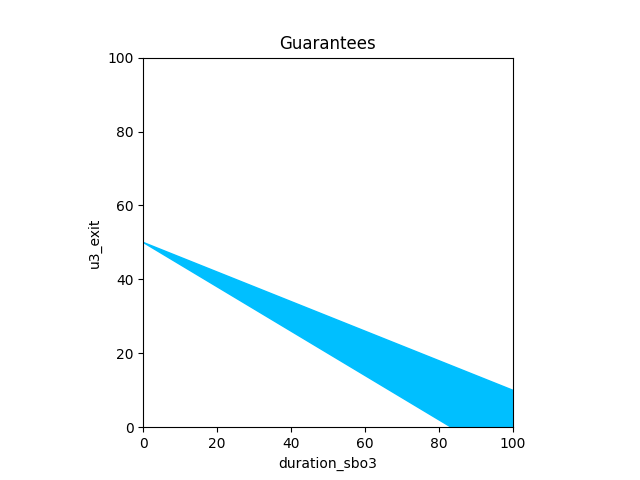

In [17]:
# Parameters:
# - s: start index of the timeline variables
# - improvement: rate of trajectory estimation uncertainty improvement during the task instance
# - epsilon: approximately zero
def SBO_nav_uncertainty(s: int, improvement: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"u{s}_entry",      # initial trajectory uncertainty
      f"duration_sbo{s}", # knob variable for SBO duration
    ],
    OutputVars = [
      f"u{s}_exit",       # final trajectory uncertainty
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_sbo{s} <= 0",

      # Upper-bound on the trajectory estimation uncertainty
      f"u{s}_entry <= 100",
    ],
    guarantees = [
      # duration*improvement(min) <= u{entry} - u{exit} <= duration*improvement(max)
      f" u{s}_entry - u{s}_exit - {improvement[1]}*duration_sbo{s} <= 0",
      f"-u{s}_entry + u{s}_exit + {improvement[0]}*duration_sbo{s} <= 0",

      # Lower-bound on the trajectory estimation uncertainty
      f"-u{s}_exit <= 0",
    ])
  return spec

sbo1_nav_uncertainty = SBO_nav_uncertainty(s=3, improvement=(0.4, 0.6))
print(f"Contract sbo1_nav:\n\n{sbo1_nav_uncertainty}")

_ = plot_guarantees(contract=sbo1_nav_uncertainty,
                x_var=Var("duration_sbo3"),
                y_var=Var("u3_exit"),
                var_values={
                  Var("u3_entry"):50,
                },
                x_lims=(0,100),
                y_lims=(0,100))

In [19]:
sbo1_nav_progress = nochangeContract(s=3, name="r")
print(f"sbo_nav_progress:\n{sbo1_nav_progress}")

sbo_nav_progress:
InVars: [r3_entry]
OutVars:[r3_exit]
A: [
]
G: [
  -r3_entry + r3_exit = 0.0
]


In [20]:
sbo1_nav = sbo1_nav_uncertainty.merge(sbo1_nav_progress)
print(f"sbo1_nav:\n{sbo1_nav}")

sbo1_nav:
InVars: [u3_entry, duration_sbo3, r3_entry]
OutVars:[u3_exit, r3_exit]
A: [
  -duration_sbo3 <= 0.0
  u3_entry <= 100.0
]
G: [
  -0.6 duration_sbo3 + u3_entry - u3_exit <= 0.0
  0.4 duration_sbo3 - u3_entry + u3_exit <= 0.0
  -u3_exit <= 0.0
  -r3_entry + r3_exit = 0.0
]
